# COMP5318 - Machine Learning and Data Mining: Assignment 1
<div style="text-align: right"> Due: Wednesday 14 Oct 2020 11:59PM </div>

The goal of this assignment is to build a classifier to classify some grayscale images of the size 28x28 into a set of categories. The dimension of the original data is large, so you need to be smart on which method you gonna use and perhaps perform a pre-processing step to reduce the amount of computation. Part of your marks will be a function of the performance of your classifier on the test set.

# Load Libraries

In [63]:
import h5py
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from bisect import bisect
from math import exp, sqrt, pi
print(os.listdir("./Input/train"))
print(os.listdir("./Input/test"))
# train_files = [name for name in os.listdir("./Input/train") if not name.endswith('DS_Store')]
# test_files = [name for name in os.listdir("./Input/test") if not name.endswith('DS_Store')]
# print(train_files)
# print(test_files)

['images_training.h5', 'labels_training.h5']
['.DS_Store', 'images_testing.h5', 'labels_testing_2000.h5']


# Load Data

In [4]:
with h5py.File('./Input/train/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with h5py.File('./Input/train/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])

# using H['datatest'], H['labeltest'] for test dataset.
print(data_train.shape,label_train.shape)

(30000, 784) (30000,)


In [6]:
with h5py.File('./Input/test/images_testing.h5','r') as H:
    data_test = np.copy(H['datatest'])
with h5py.File('./Input/test/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])

# using H['datatest'], H['labeltest'] for test dataset.
print(data_test.shape,label_test.shape)

(5000, 784) (2000,)


# Principal Component Analysis


<div style="text-align: right"> Sourced: https://stats.stackexchange.com/questions/125172/pca-on-train-and-test-datasets-should-i-run-one-pca-on-traintest-or-two-separa </div>
<div style="text-align: right"> https://towardsdatascience.com/pca-with-numpy-58917c1d0391 </div>
<div style="text-align: right"> https://stackoverflow.com/questions/10818718/principal-component-analysis </div>



## Computing the Eigenvectors and Eigenvalues


In [8]:
data = data_train
data = data - np.mean(data, axis=0)
print(data.shape)
covariance_matrix = np.cov(data.T)
#print(covariance_matrix)
eig_val, eig_vec = np.linalg.eig(covariance_matrix)
print("First 20 Eigenvalues: \n", eig_val[:20], "\n")

(30000, 784)
First 20 Eigenvalues: 
 [19.8611004  12.10997382  4.1078177   3.3719857   2.61461635  2.35693788
  1.61184549  1.28149922  0.92593176  0.89463432  0.67365696  0.62224642
  0.52434522  0.44943814  0.41495554  0.4023021   0.37964251  0.36276613
  0.31522305  0.31177036] 



## Picking Principal Components


In [10]:
variance_explained = []
for i in eig_val:
    variance_explained.append((i/sum(eig_val))*100)     
print("First 10 Variance Explained: \n", variance_explained[:10], "\n") 

cumulative_variance_explained = np.cumsum(variance_explained)
print("First 10 Cummulative Variance Explained: \n", cumulative_variance_explained[:10], "\n") 

First 10 Variance Explained: 
 [29.077053310731294, 17.72924699012503, 6.013928330120427, 4.936655363514209, 3.8278512994969107, 3.4506048031981504, 2.3597744497586266, 1.876140819639972, 1.3555828542550032, 1.309762764368793] 

First 10 Cummulative Variance Explained: 
 [29.07705331 46.8063003  52.82022863 57.75688399 61.58473529 65.0353401
 67.39511455 69.27125537 70.62683822 71.93660099] 



### Plot Cumulative explained variance to find elbow point

Number of components for 95% Explained Variance: 187


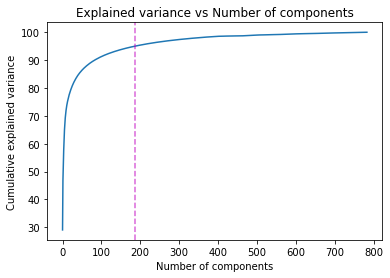

In [12]:
comp = bisect(cumulative_variance_explained, 95) #Number of components at 95% explained variance
sns.lineplot(x = np.arange(data.shape[1]), y=cumulative_variance_explained)
plt.axvline(comp, c='m', linestyle='--', alpha=0.6)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Explained variance vs Number of components")
print("Number of components for 95% Explained Variance:", comp)

## Project Data Onto Lower-Dimensional Linear Subspace

### Project onto training data

In [14]:
n_component = comp
projection_matrix = (eig_vec.T[:][:n_component]).T
X_train_pca = data.dot(projection_matrix)

print(X_train_pca.shape)

(30000, 187)


### Project on to test data

In [16]:
data = data_test
data = data - np.mean(data, axis=0)
X_test_pca = data.dot(projection_matrix)

print(X_test_pca.shape)

(5000, 187)


# Split Data
Split training data into train and validaiton sets on 70:30

In [18]:
train_pct_index = int(0.7 * X_train_pca.shape[0])
print(train_pct_index)
X_train, X_val = X_train_pca[:train_pct_index], X_train_pca[train_pct_index:]
y_train, y_val = label_train[:train_pct_index], label_train[train_pct_index:]
# print(np.sum(X_train_pca[:train_pct_index] == X_train)/len(X_train_pca[:train_pct_index]))
# print(X_train[1])
# print(X_test_pca[1])
print(np.all(X_train[:10] == X_train_pca[:10]))
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

21000
True
(21000, 187)
(9000, 187)
(21000,)
(9000,)


# Multi Logistic Regression Classifier

In [96]:
def softmax(Z): # TODO
    e_Z = np.exp(Z)
    A = e_Z / e_Z.sum(axis = 1, keepdims = True)
    return A

In [97]:
# calculate gradient 
def softmax_grad(X, y, W):
    A = softmax(X.dot(W))    # shape of (N, C)
    id0 = range(X.shape[0])  # number of train data
    A[id0, y] -= 1           # A - Y, shape of (N, C)
    return X.T.dot(A)/X.shape[0]
    '''
    onehot = np.zeros((len(y), C ))
    onehot[np.arange(len(y)), y] = 1
    A = softmax_stable(x.dot(W))
    A = A - onehot
    x.T.dot(A2)/x.shape[0]
    '''

In [98]:
# cost or loss function  
def softmax_loss(X, y, W):
    A = softmax(X.dot(W))
    id0 = range(X.shape[0])
    return -np.mean(np.log(A[id0, y]))

In [99]:
# building learning function using softmax gradient descent
def softmax_fit(X, y, W, lr = 0.01, nepoches = 100, tol = 1e-5, batch_size = 10):
    W_old = W.copy()
    ep = 0 
    loss_hist = [softmax_loss(X, y, W)] # store history of loss 
    N = X.shape[0]
    nbatches = int(np.ceil(float(N)/batch_size))
    while ep < nepoches: 
        ep += 1 
        mix_ids = np.random.permutation(N) # mix data 
        for i in range(nbatches):
            # get the i-th batch
            batch_ids = mix_ids[batch_size*i:min(batch_size*(i+1), N)] 
            X_batch, y_batch = X[batch_ids], y[batch_ids]
            W -= lr*softmax_grad(X_batch, y_batch, W) # update gradient descent # TODO
        loss_hist.append(softmax_loss(X, y, W))
        if np.linalg.norm(W - W_old)/W.size < tol:
            break 
        W_old = W.copy()
    return W, loss_hist 

# predict function
def pred(W, X):
    A = softmax(X.dot(W))
    return np.argmax(A, axis = 1)

In [101]:
C=len(np.unique(y_val))
#weights = np.random.random((len(np.unique(y_train)), D))
W_init = np.random.randn(X_train.shape[1], C)
W, loss_hist = softmax_fit(X_train, y_train, W_init, batch_size = 1000, nepoches = 1000, lr = 0.05)

In [102]:
y_pre = pred(W,X_val)

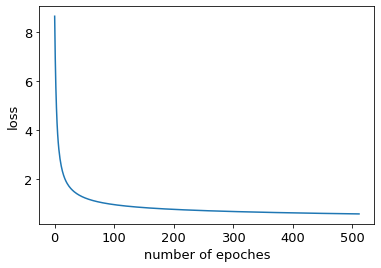

In [105]:
plt.plot(loss_hist)
plt.xlabel('number of epoches', fontsize = 13)
plt.ylabel('loss', fontsize = 13)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.show()

In [104]:
y_actu = pd.Series(y_val, name='Actual')
y_pred = pd.Series(y_pre, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print(df_confusion)
# acc = get_accuracy(pred, y_train)
# print(acc)
print("\nAccuracy:", np.mean(y_pred == y_actu))

Predicted    0    1    2    3    4    5    6    7    8    9
Actual                                                     
0          733    7   22   62    5    7   88    1   12    0
1            5  822   10   20    4    0    4    3    1    0
2           17    7  609   14  112    6   89    1   12    1
3           37   13   19  762   26    2   25    5    4    1
4            6    5   94   37  659    1  100    0   10    0
5            2    0    0    4    0  860    1   49   14   21
6          134    3  101   32  104   11  476    2   20    0
7            0    1    0    0    0   78    0  827    4   43
8            5    1    5   11   10   17   24   10  801    1
9            0    0    0    0    0   31    0   25    3  789

Accuracy: 0.8153333333333334


# Train Model

# Training Confusion Matrix

# Calculate Test Dataset
<div style="text-align: right"> Sourced: COMP5318 Tutorial 5 - Classification I </div>


# Test Confusion Matrix